In [16]:
import json
import os
import matplotlib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns

from collections import namedtuple
from tqdm import tqdm

sns.set()

In [2]:
data_prefix = "../datasets"
comment_dataset = "RC_2018-02-28.filtered"
glove_dim = 200

In [3]:
comment_dataset_path = os.path.join(data_prefix, comment_dataset)

In [4]:
comments_df = pd.read_json(comment_dataset_path, lines=True, chunksize=1e4).read()
controversial_comments_df = comments_df[
    (comments_df.controversiality != 0) &
    (comments_df.body != '[deleted]') &
    (comments_df.body != '[removed]')
]

Text(0.5,1,'Comment lengths')

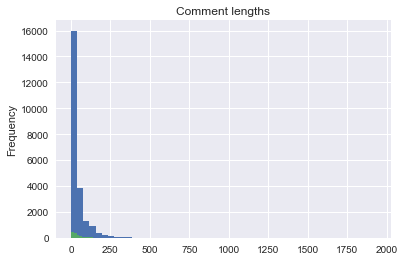

In [7]:
comment_lens = comments_df['body'].apply(nltk.tokenize.word_tokenize).str.len()
controversial_comments_lens = controversial_comments_df['body'].apply(nltk.tokenize.word_tokenize).str.len()

plt.figure()
comment_lens.plot.hist(bins=50)
controversial_comments_lens.plot.hist(bins=50)
plt.title('Comment lengths')

In [13]:
# Parse GloVe vectors

PAD_TOKEN = b"<PAD>"
PAD_ID = 0

UNK_TOKEN = b"<UNK>"
UNK_ID = 1

def get_glove(glove_dim, vocab_size=4e5):    
    initial_vocab = [PAD_TOKEN, UNK_TOKEN]
    embed_matrix = np.zeros((int(vocab_size + len(initial_vocab)), glove_dim))
    word2id = {word: idx for idx, word in enumerate(initial_vocab)}
    
    glove_path = os.path.join(data_prefix, 'glove.6B', f"glove.6B.{glove_dim}d.txt")
    
    with open(glove_path, 'r') as infile:        
        for idx, line in enumerate(tqdm(infile, total=vocab_size)):
            idx_offset = idx + len(initial_vocab)
            
            word, word_vec_raw = line.strip().split(maxsplit=1)
            word_vec = np.array([float(v) for v in word_vec_raw.split()])
            
            embed_matrix[idx_offset, :] = word_vec
            word2id[word] = idx_offset
    
    id2word = {v: k for k, v in word2id.items()}
    return embed_matrix, word2id, id2word

In [14]:
embed_matrix, word2id, id2word = get_glove(glove_dim)

100%|██████████| 400000/400000.0 [00:48<00:00, 8245.37it/s]


In [23]:
Batch = namedtuple('Batch', ['comment_tokens', 'comment_ids', 'comment_masks', 'controversialities'])

def parse_comment(comment, word2id, max_comment_len=200):
    comment_tokens = nltk.tokenize.word_tokenize(comment['body'])[:max_comment_len]
    if len(comment_tokens) < max_comment_len:
        comment_tokens += [PAD_TOKEN] * (max_comment_len - len(comment_tokens))
    
    comment_ids = np.array([word2id.get(token, UNK_ID) for token in comment_tokens])
    comment_mask = (comment_ids != PAD_ID).astype(np.int32)
    
    controversiality = comment['controversiality']
    return (comment_tokens, comment_ids, comment_mask, controversiality)
    
    
def create_batch(parsed_comments):
    grouped = list(zip(*parsed_comments))
    return Batch(
        comment_tokens=grouped[0],
        comment_ids=np.array(grouped[1]),
        comment_masks=np.array(grouped[2]),
        controversialities=np.array(grouped[3]),
    )
    

def generate_batches(dataset_path, word2id, batch_size=100):
    """An infinite generator of batches. Just keeps looping through
    the training dataset forever, generating batches.
    """
    parsed_comments = []
    
    while True:
        with open(dataset_path, 'r') as infile:
            parsed_comments = []
            for idx, line in enumerate(infile):
                comment = json.loads(line)
                parsed_comments.append(parse_comment(comment, word2id))
                
                if len(parsed_comments) == batch_size:
                    batch = create_batch(parsed_comments)
                    parsed_comments = []
                    yield batch

test = generate_batches(comment_dataset_path, word2id)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int32)